## Project : Spooky_Author_Identification

This is a competition to identify an auther from sentences which they wrote.
This project follows the instructions of a Kaggle competition during the Halloween of 2017.
The link of the competition is https://www.kaggle.com/c/spooky-author-identification

### Data description

The competition dataset contains text from works of fiction written by spooky authors of the public domain: Edgar Allan Poe, HP Lovecraft and Mary Shelley. The data was prepared by chunking larger texts into sentences using CoreNLP's MaxEnt sentence tokenizer, so you may notice the odd non-sentence here and there. Your objective is to accurately identify the author of the sentences in the test set.

In [21]:
import re
import nltk

from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize,word_tokenize
from nltk.stem.snowball import SnowballStemmer
from wordcloud import WordCloud, STOPWORDS

import matplotlib.pyplot as plt

%matplotlib inline

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sunghwanki/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/sunghwanki/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## 1. Load and check data
### 1.1 Load data

In [22]:
# Load train and Test set
train = pd.read_csv('../3_spooky-author-identification/data/train.csv')
test = pd.read_csv('../3_spooky-author-identification/data/test.csv')

# Store author data at y_train
# y_train = train['author']

# Take a look at the first 5 rows in the data
train.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [23]:
# Check the data set
print("Train data : ", train.shape)
print("Test  data : ", test.shape)

Train data :  (19579, 3)
Test  data :  (8392, 2)


In [24]:
# Check the train data set's columns
print("Train data columns Qty :", len(train.columns), "\n\n")
print("Train data columns :", train.columns)

Train data columns Qty : 3 


Train data columns : Index(['id', 'text', 'author'], dtype='object')


According to the competition page there are three distinct author initials


1. EAP - Edgar Allen Poe : American writer who wrote poetry and short stories that revolved around tales of mystery and the grisly and the grim. Arguably his most famous work is the poem - "The Raven" and he is also widely considered the pioneer of the genre of the detective fiction.


2. HPL - HP Lovecraft : Best known for authoring works of horror fiction, the stories that he is most celebrated for revolve around the fictional mythology of the infamous creature "Cthulhu" - a hybrid chimera mix of Octopus head and humanoid body with wings on the back.


3. MWS - Mary Shelley : Seemed to have been involved in a whole panoply of literary pursuits - novelist, dramatist, travel-writer, biographer. She is most celebrated for the classic tale of Frankenstein where the scientist Frankenstein a.k.a "The Modern Prometheus" creates the Monster that comes to be associated with his name.

Visualize some basic statistics in the data, like the distribution of entries for each author. 

For this purpose, I will invoke the handy visualisation library and plot some simple bar plots.

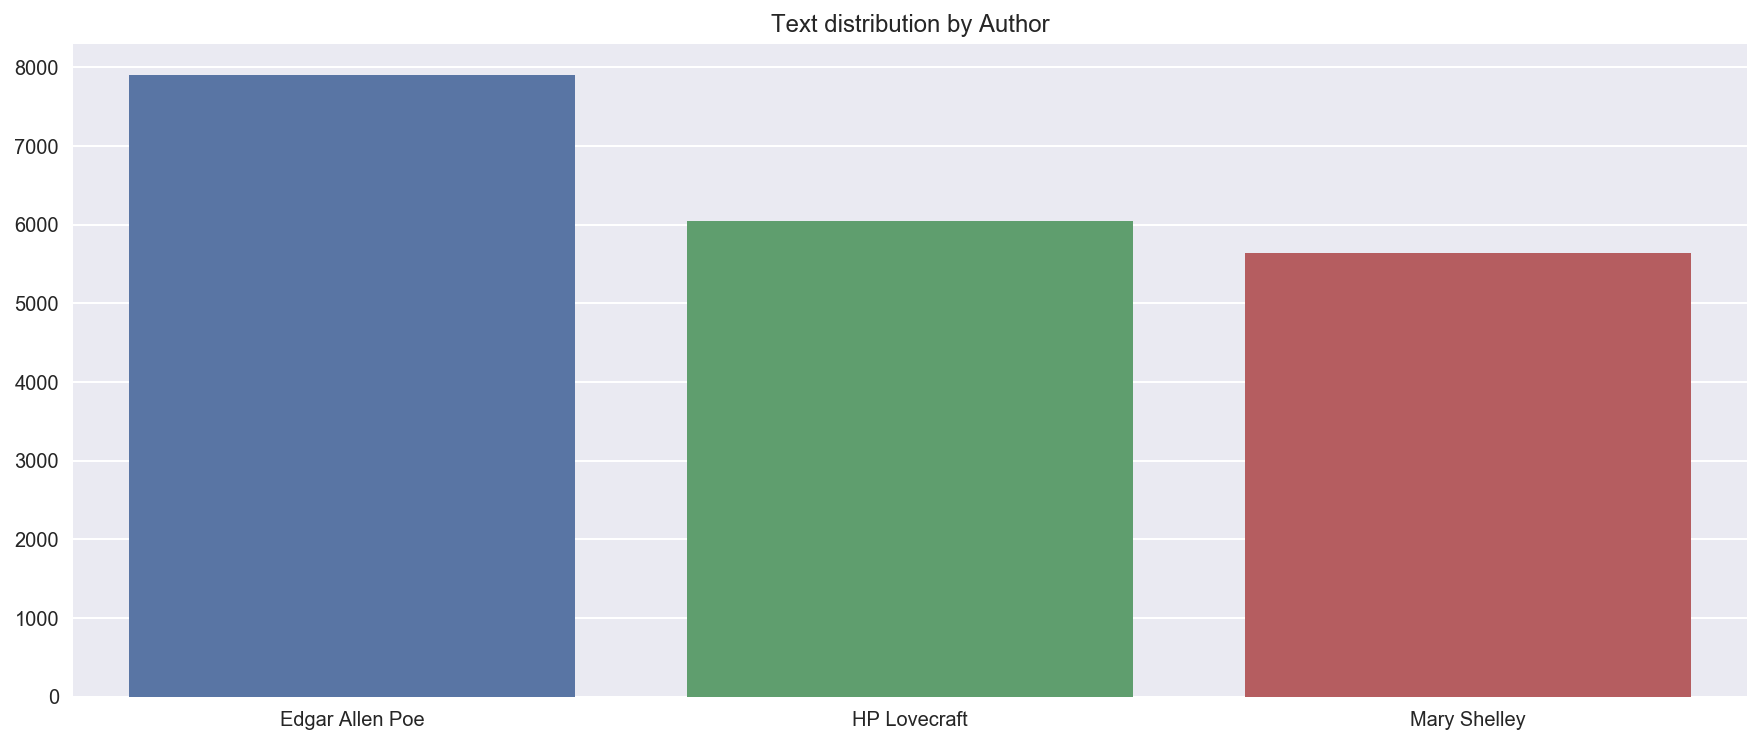

In [25]:
z = {'EAP': 'Edgar Allen Poe', 'MWS': 'Mary Shelley', 'HPL': 'HP Lovecraft'}

plt.figure(figsize=(15,6))
g = sns.barplot(x = train.author.map(z).unique(),
            y = train.author.value_counts().values)
g.set_title('Text distribution by Author')
plt.show()

In [26]:
all_words = train['text'].str.split(expand=True).unstack().value_counts()

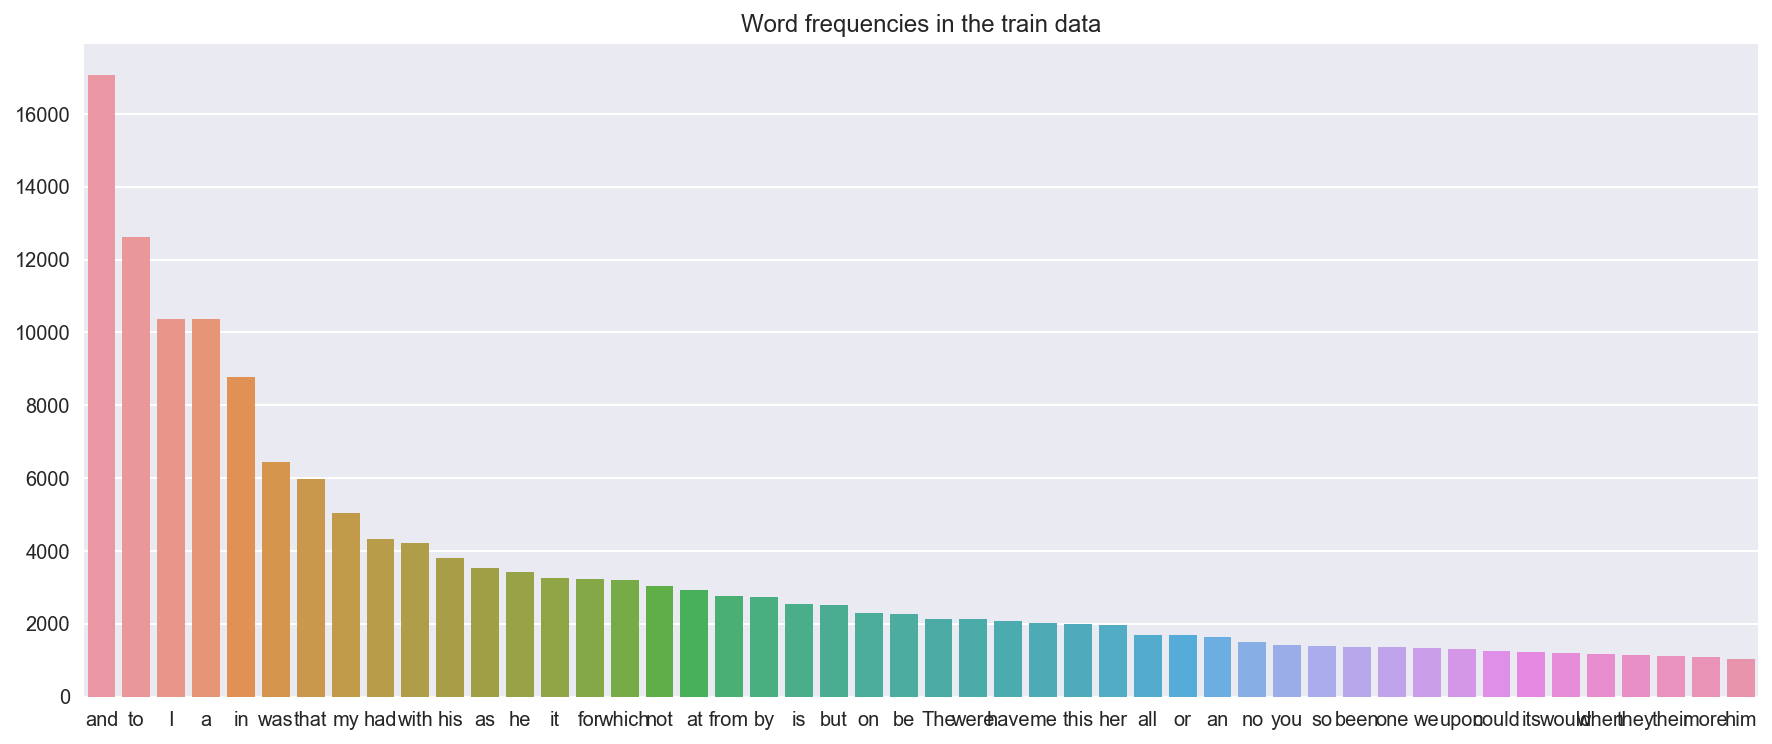

In [27]:
plt.figure(figsize=(15,6))
g = sns.barplot(x = all_words.index.values[2:50],
            y = all_words.values[2:50])
g.set_title('Word frequencies in the train data')
plt.show()

### 1.2 Word cloud
- A visualization method that can be used when you have the frequency of words data
- The importance of each word is shown with font size or color
- This format is useful for quickly perceiving the most prominent terms and for locating a term alphabetically to determine its relative prominence

Create three different python lists that store the texts of Edgar Allen Poe(EAP), Mary Shelley(MWS), HP Lovecraft(HPL) respectively

In [28]:
# Classify by author
EAP = train[train['author']=='EAP']
MWS = train[train['author']=='MWS']
HPL = train[train['author']=='HPL']

(-0.5, 399.5, 199.5, -0.5)

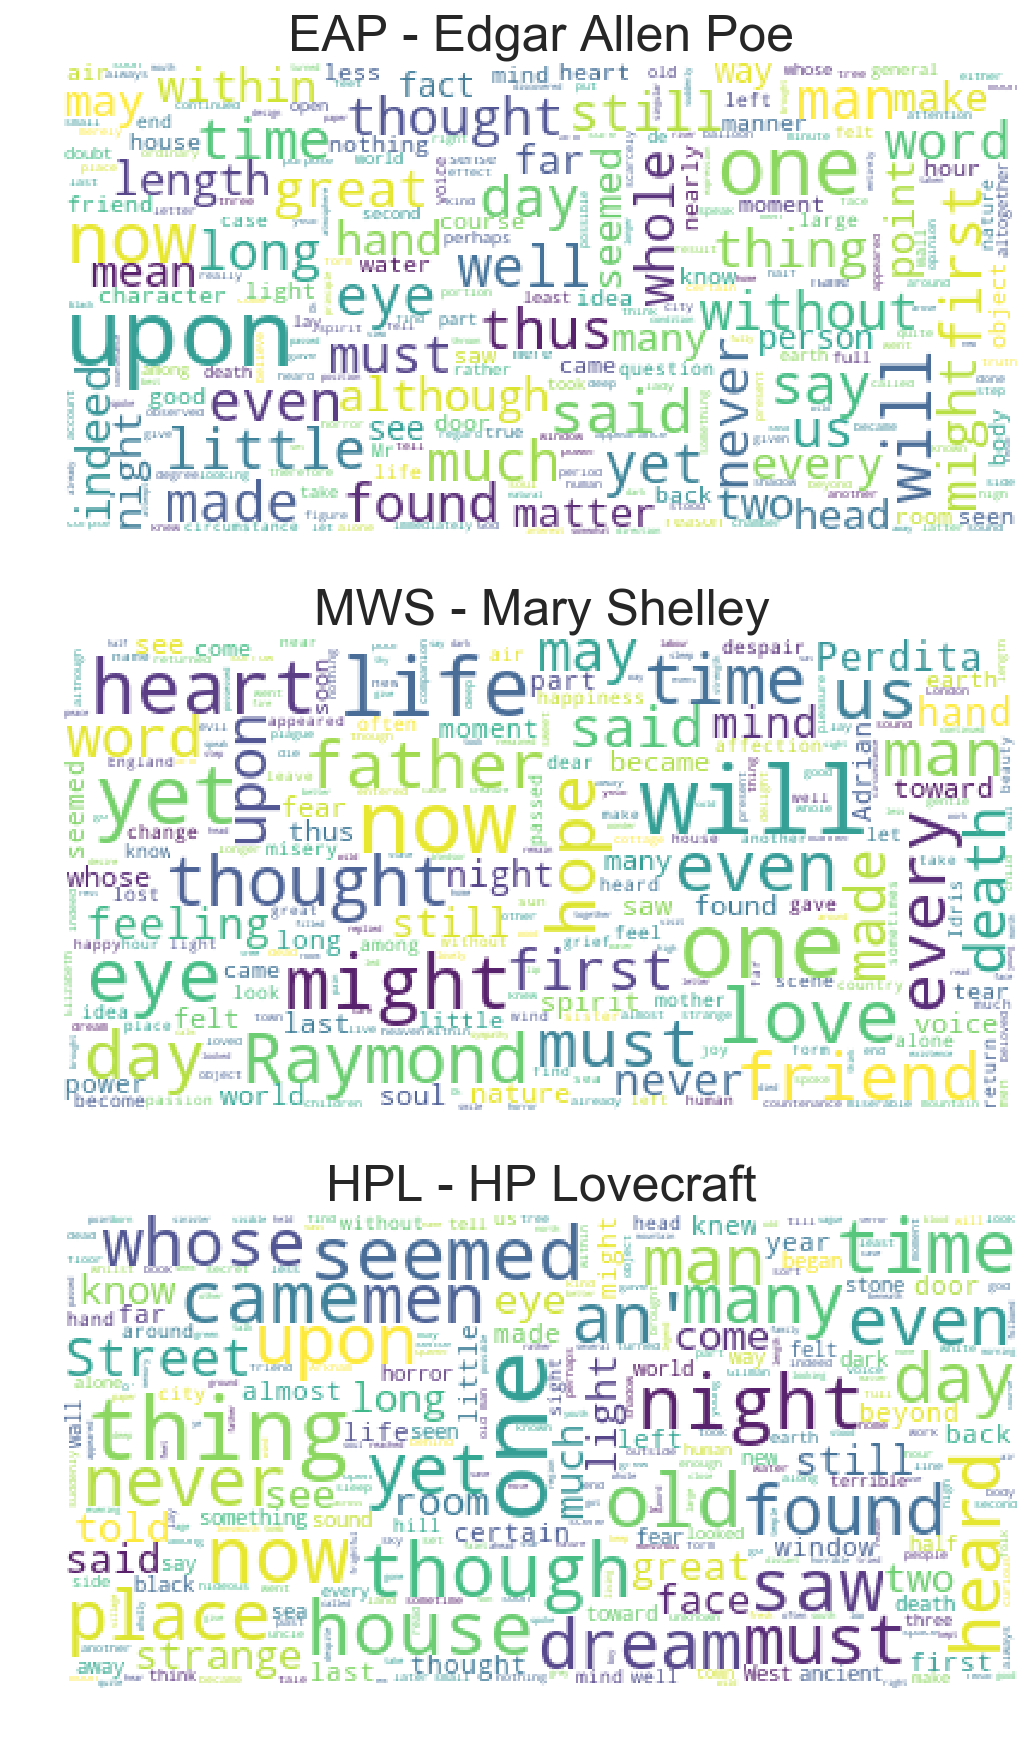

In [29]:
plt.figure(figsize=(20,15))
plt.subplot(311)
wc = WordCloud(background_color="white", max_words=10000, 
               stopwords=STOPWORDS, max_font_size= 40)

wc.generate(" ".join(EAP.text))
plt.title("EAP - Edgar Allen Poe", fontsize=25)
plt.imshow(wc.recolor( colormap= 'viridis' , random_state=17), alpha=0.9)
plt.axis('off')

plt.subplot(312)
wc.generate(" ".join(MWS.text))
plt.title("MWS - Mary Shelley", fontsize=25)
plt.imshow(wc.recolor( colormap= 'viridis' , random_state=17), alpha=0.9)
plt.axis('off')

plt.subplot(313)
wc.generate(" ".join(HPL.text))
plt.title("HPL - HP Lovecraft", fontsize=25)
plt.imshow(wc.recolor(colormap = 'viridis', random_state=17), alpha=0.9)
plt.axis('off')

In [30]:
train['sentences'] = train.text.transform(lambda x: len(sent_tokenize(x)))
train['words'] = train.text.transform(lambda x: len(word_tokenize(x)))
train['text_length'] = train.text.transform(lambda x: len(x))

test['sentences'] = test.text.transform(lambda x: len(sent_tokenize(x)))
test['words'] = test.text.transform(lambda x: len(word_tokenize(x)))
test['text_length'] = test.text.transform(lambda x: len(x))

text_analize = train.groupby("author")[['sentences','words','text_length']].sum()
text_analize

,sentences,words,text_length
author,,,
EAP,8206,232184,1123585
HPL,5876,173979,878178
MWS,6128,188824,916632


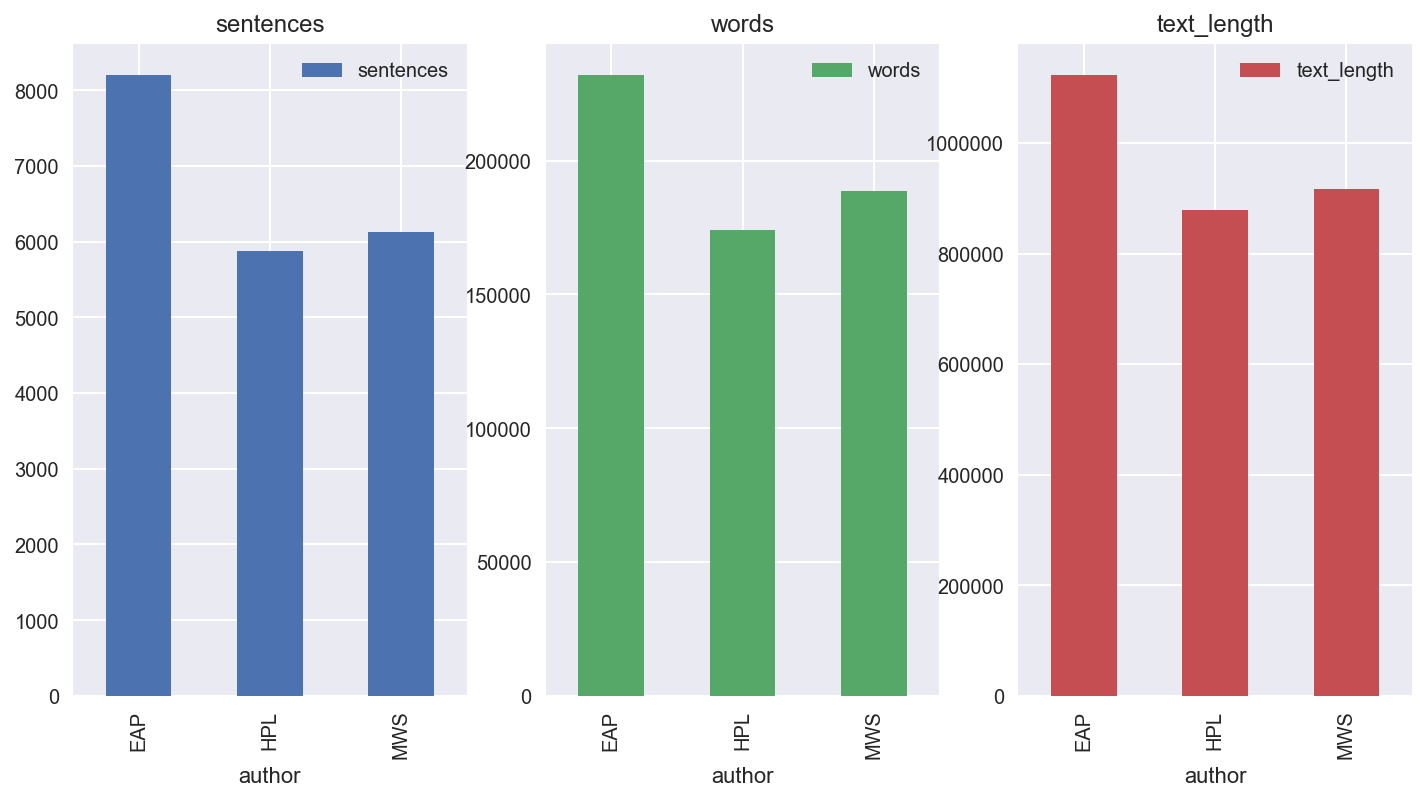

In [31]:
text_analize.plot.bar(subplots = True, layout=(1,3), figsize=(12,6))
plt.show()

## 2. Natural Language Processing

### 2.1 Stopword Removal

Generally, words that appear frequently in corpus are learning models and do not really contribute to the learning or prediction process, so they can not distinguish them from other texts. For example, words such as survey, suffix, i, me, my, it, this, that, is, and are often appear but do not contribute much to finding the actual meaning. Stopwords include terms such as "to" or "the" and should be removed at the pre-processing stage. NLTK has 179 predefined English language abbreviations.

In [40]:
len(stopwords.words('english')), stopwords.words('english')[:5]

(179, ['i', 'me', 'my', 'myself', 'we'])

### 2.2 Stemming

Stemming refers to the removal of affixes from the modified word in the morphology and information retrieval field, and separating the stem of the word. In this case, the stem is not necessarily the same as the root, and it is the purpose of the stem extraction that the related words are mapped to the same stem even if there is a difference from the root.

In [32]:
stopwords.words

<bound method WordListCorpusReader.words of <WordListCorpusReader in '/Users/sunghwanki/nltk_data/corpora/stopwords'>>

In [33]:
stemmer = SnowballStemmer('english')

def text_to_words(text):

    # Convert non-English characters to spaces
    letters_only = re.sub('[^a-zA-Z]', ' ', text)
    
    # Lowercase conversion
    words = letters_only.lower().split()
    
    # Convert stopwords to sets.
    stops = set(stopwords.words('english'))
    
    # Remove Stopwords 
    meaningful_words = [w for w in words if not w in stops]
    
    # Stemming
    stemming_words = [stemmer.stem(w) for w in meaningful_words]
    
    # Combining with a space-delimited string
    return( ' '.join(stemming_words) )

### 2.3 Improved workflow

In order to preprocess a large amount of text data, it is necessary to improve the workflow. The threading-based multiprocessing package improves the speed of work, thus reducing work time

In [34]:
# Improved workflow processing speed
from multiprocessing import Pool

def _apply_df(args):
    df, func, kwargs = args
    return df.apply(func, **kwargs)

def apply_by_multiprocessing(df, func, **kwargs):
    # Get workers parameter from keyword item
    workers = kwargs.pop('workers')
    
    # Define a process pool with the number of workers
    pool = Pool(processes = workers)
    
    # Work by dividing the number of functions and data frames 
    # to be executed by the number of workers
    result = pool.map(_apply_df, [(d, func, kwargs)
            for d in np.array_split(df, workers)])
    pool.close()
    
    # Combine work
    return pd.concat(list(result))

### 2.4 Put all the preprocessing steps together 

Now, stopword removal and stemming are used to preprocess text data using an improved workflow

In [41]:
# Proprocessing text data in a train
train_clean = apply_by_multiprocessing(train['text'], text_to_words, workers=4)

# Proprocessing text data by author
EAP_clean = apply_by_multiprocessing(EAP['text'], text_to_words, workers=4)
MWS_clean = apply_by_multiprocessing(MWS['text'], text_to_words, workers=4)
HPL_clean = apply_by_multiprocessing(HPL['text'], text_to_words, workers=4)

In [42]:
EAP_clean.head(3)

0    process howev afford mean ascertain dimens dun...
2    left hand gold snuff box caper hill cut manner...
6    astronom perhap point took refug suggest non l...
Name: text, dtype: object

In [43]:
# Number of words
train['num_words'] = train_clean.apply(lambda x: len(str(x).split()))

# Number of words without duplicates
train['num_uniq_words'] = train_clean.apply(lambda x: len(set(str(x).split())))

Average of number of words per text : 13.076612697277696
Median of number of words per text 11.0
Average of number of unique words per text: 12.723121712038408
Median of number of unique words per tex 11.0


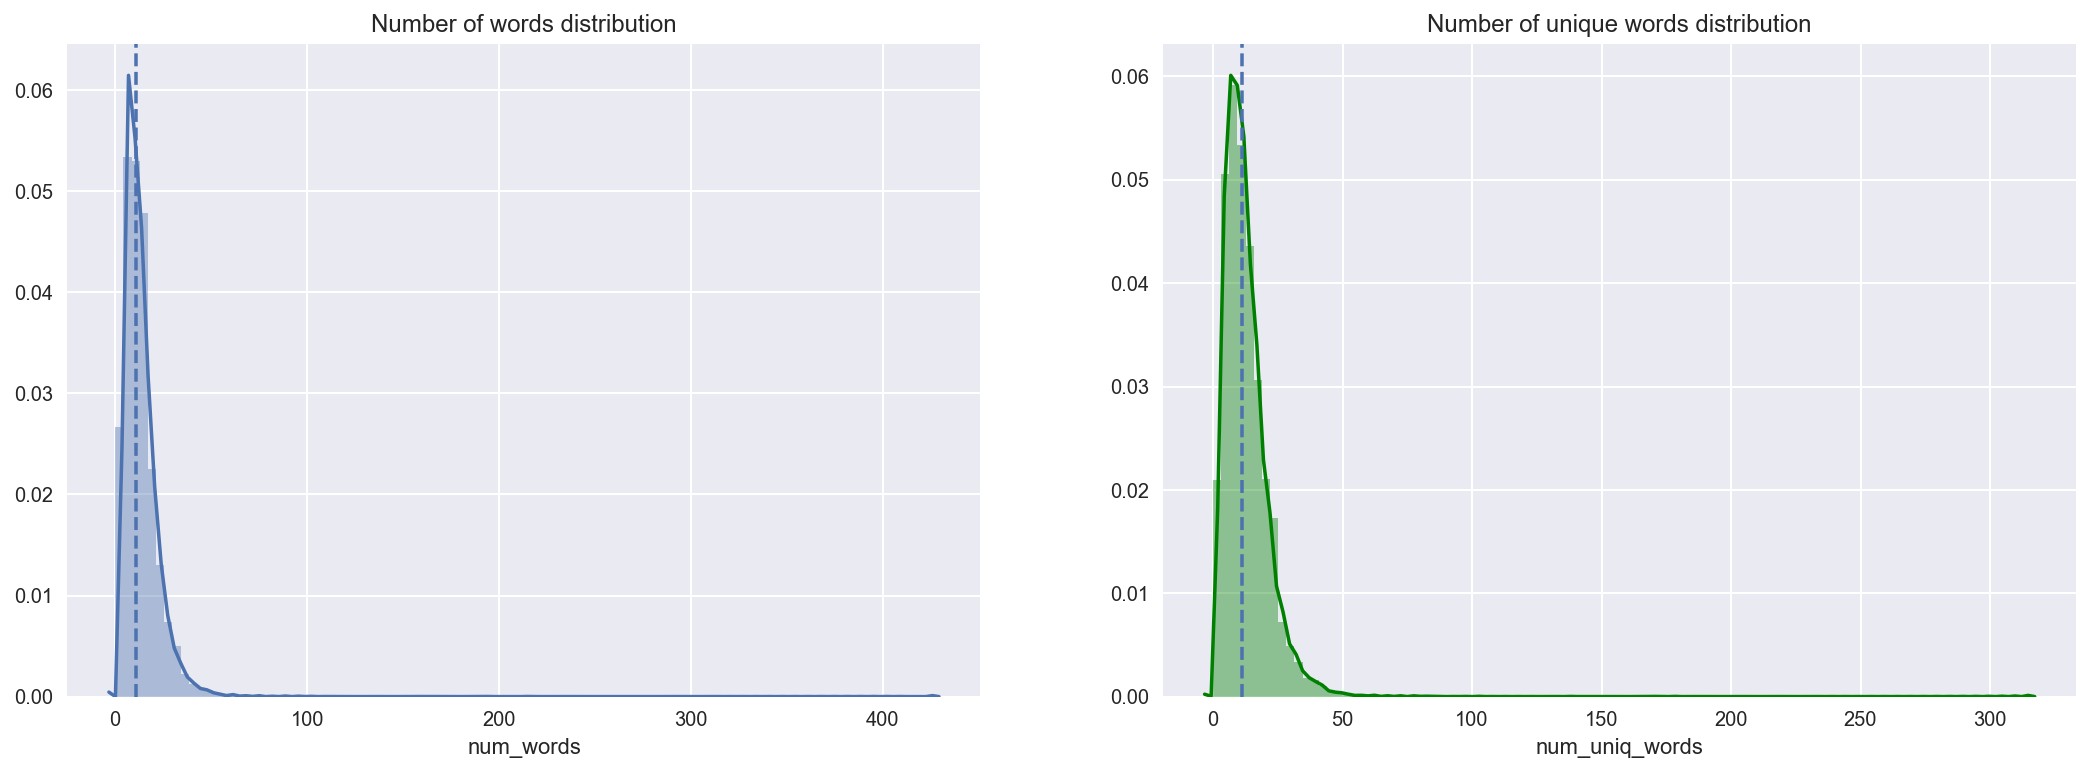

In [44]:
import seaborn as sns

fig, axes = plt.subplots(ncols=2)
fig.set_size_inches(18, 6)
print('Average of number of words per text :', train['num_words'].mean())
print('Median of number of words per text', train['num_words'].median())
sns.distplot(train['num_words'], bins=100, ax=axes[0])
axes[0].axvline(train['num_words'].median(), linestyle='dashed')
axes[0].set_title('Number of words distribution')

print('Average of number of unique words per text:', train['num_uniq_words'].mean())
print('Median of number of unique words per tex', train['num_uniq_words'].median())
sns.distplot(train['num_uniq_words'], bins=100, color='g', ax=axes[1])
axes[1].axvline(train['num_uniq_words'].median(), linestyle='dashed')
axes[1].set_title('Number of unique words distribution')
plt.show()

## 3. Vectorization of data

### 3.1 CountVectorizer

* Convert a collection of text documents to a matrix of token counts
* Specify the minimum number of documents for which tokens will appear with min_df.

In [45]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline


# Creating a vectorizer object
vectorizer = CountVectorizer(analyzer = 'word', 
                             tokenizer = None,
                             preprocessor = None, 
                             stop_words = None, 
                             min_df = 2, 
                             ngram_range=(1, 3),
                             max_features = 20000
                            )
vectorizer

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=20000, min_df=2,
        ngram_range=(1, 3), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [46]:
# Use pipelines to improve speed
pipeline = Pipeline([
    ('vect', vectorizer),
])  

In [47]:
# Convert train data to vector
X_train = pipeline.fit_transform(train_clean)
X_train

<19579x20000 sparse matrix of type '<class 'numpy.int64'>'
	with 278739 stored elements in Compressed Sparse Row format>

In [48]:
# Check the shape of vectorized data
X_train.shape

(19579, 20000)

In [49]:
# Save the name of the column in the vocab variable
vocab = vectorizer.get_feature_names()

# Total number of words
sum_of_word = np.sum(X_train, axis=0)

# Check the total of each word
pd.DataFrame(sum_of_word, columns=vocab, index=['Total'])

,abandon,abaout,abat,abbey,abdic,abdul,abdul alhazr,abernethi,aberr,abey,...,zigzag,zigzag direct,zimmer,zit,zit still,zodiac,zodiac light,zokkar,zokkar olden,zone
Total,48,24,6,5,7,5,5,4,6,3,...,5,2,3,5,2,3,2,3,2,3


In [50]:
# Check vectorized features
pd.DataFrame(X_train[:10].toarray(), columns=vocab).head()

,abandon,abaout,abat,abbey,abdic,abdul,abdul alhazr,abernethi,aberr,abey,...,zigzag,zigzag direct,zimmer,zit,zit still,zodiac,zodiac light,zokkar,zokkar olden,zone
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 4. Model

### 4.1 Prepare for input data

In [51]:
test_clean = apply_by_multiprocessing(test['text'], text_to_words, workers=4)

In [52]:
# Vectorize Test data
X_test = pipeline.transform(test_clean)

In [55]:
y_train = train.author.map({'EAP' : 0, 'HPL' : 1, 'MWS' : 2})

### 4.2 Modeling

### 4.2.1 Random forest

 - Random Forest is a model combining method that uses Decision Tree as an individual model.
 
 
 - At the time of node separation, the independent variable dimension is reduced randomly and then independent variable is selected. This reduces the variability of model performance because the correlation between individual models is reduced

tree1_cross_val_scroe:0.4064053347168411
tree2_cross_val_scroe:0.4106958442050563
tree3_cross_val_scroe:0.4158036706451214
tree4_cross_val_scroe:0.4218302805517816
tree5_cross_val_scroe:0.43107505964550397
tree6_cross_val_scroe:0.43980859156230767
tree7_cross_val_scroe:0.4479292010086106
tree8_cross_val_scroe:0.4566631243857334
tree9_cross_val_scroe:0.46493718627717584
tree10_cross_val_scroe:0.46999352263658445
tree11_cross_val_scroe:0.47780824498943836
tree12_cross_val_scroe:0.485929350285479
tree13_cross_val_scroe:0.4931821704961054
tree14_cross_val_scroe:0.5004348341226044
tree15_cross_val_scroe:0.5070234505609106
tree16_cross_val_scroe:0.511825024544562
tree17_cross_val_scroe:0.5174428976832335
tree18_cross_val_scroe:0.5215799025316
tree19_cross_val_scroe:0.5295989149763846


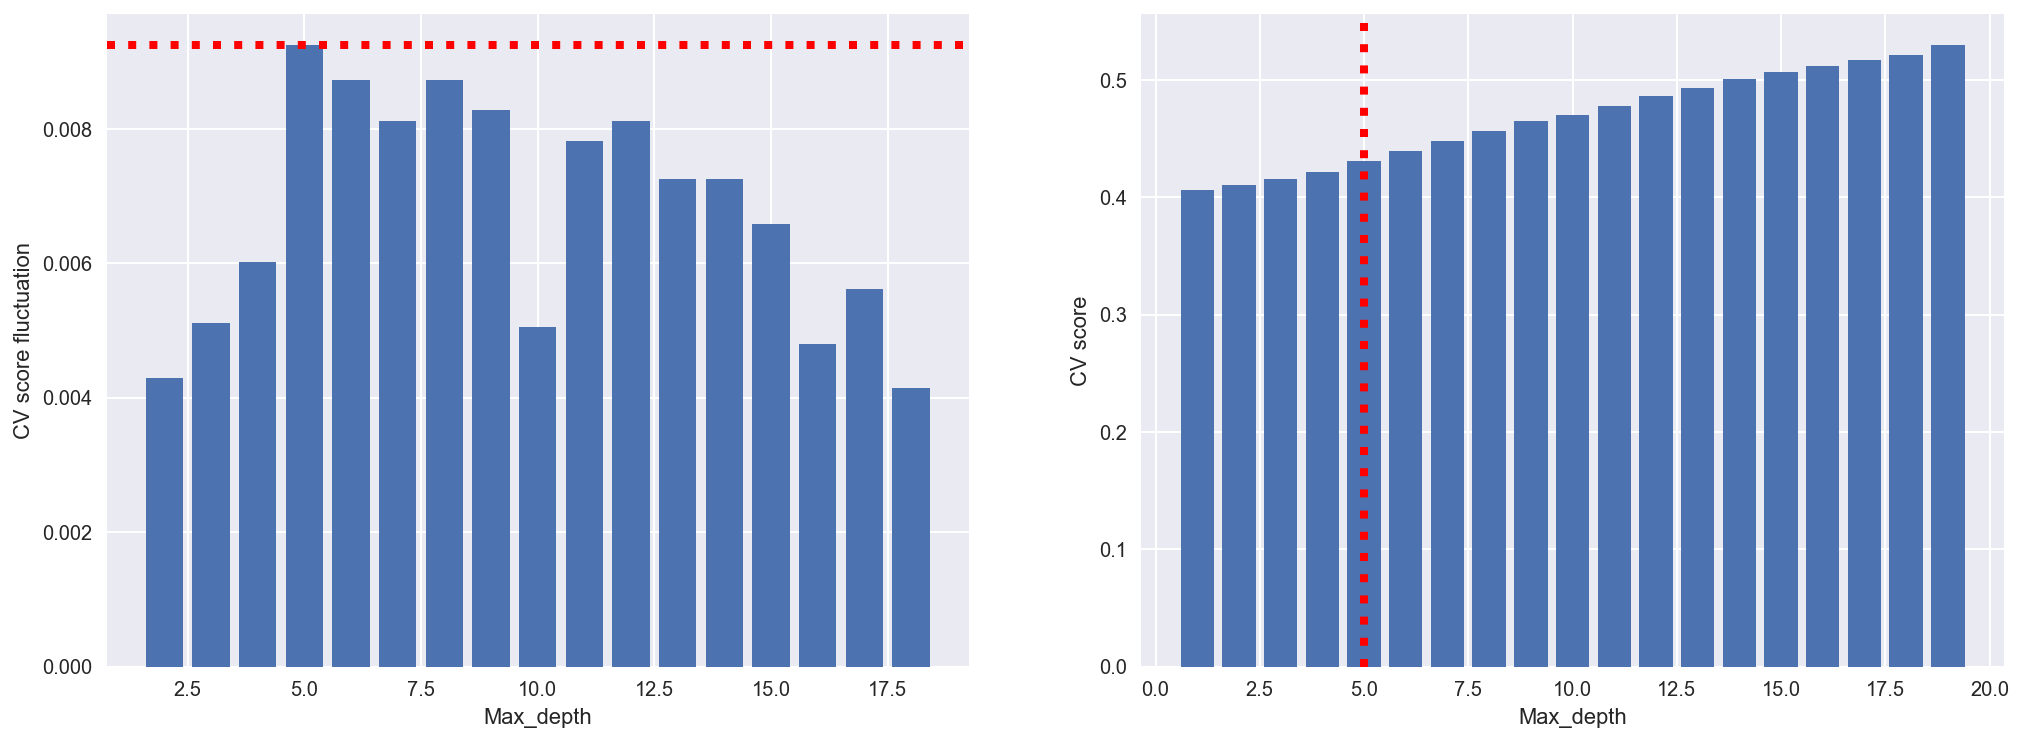

In [116]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# Setup the K-Fold
k_fold = KFold(n_splits=10, shuffle=True, random_state=1)

# Score list
scores = []
max_depth_list =[]
diff_list = []
pre_score = 0
# Use Random Forest Classifier
for max_depth in range(1,20):
    globals()['tree%s' % max_depth] = RandomForestClassifier(max_depth=max_depth, n_estimators=10, random_state=1).fit(X_train, y_train)
    score = cross_val_score(globals()['tree%s' % max_depth],X_train, y_train, cv=k_fold, n_jobs=-1, scoring="accuracy").mean()
    print('{}_cross_val_scroe:{}'.format('tree%s' % max_depth, score))
    scores.append(score)
    max_depth_list.append(max_depth)
    diff = score - pre_score 
    pre_score = score
    diff_list.append(diff)

plt.figure(figsize=(17,6))

plt.subplot(121)
plt.bar(max_depth_list[1:-1], diff_list[1:-1])
plt.ylabel('CV score fluctuation')
plt.xlabel('Max_depth')
plt.axhline(np.max(diff_list[1:-1]), linestyle=':', c = 'r', linewidth=4)

plt.subplot(122)
plt.bar(max_depth_list, scores)
plt.ylabel('CV score')
plt.xlabel('Max_depth')
diff_list_max_index = np.argmax(diff_list[1:-1]) + 2
plt.axvline(diff_list_max_index, linestyle=':', c = 'r', linewidth=4)

plt.show()

In [109]:
# The performance is best when max_depth is 5
model_1 = RandomForestClassifier(max_depth=5, n_estimators=10,  random_state=1).fit(X_train, y_train)

In [117]:
print("Score : {}".format(scores[diff_list_max_index-1]))

Score : 0.43107505964550397


In [129]:
from sklearn.metrics import *
print("Confusion Matrix : \n", confusion_matrix(y_train, model_1.predict(X_train)), "\n\n")
print("10-fold Cross Validation Report: \n",classification_report(y_train, model_1.predict(X_train)))

Confusion Matrix : 
 [[7844    2   54]
 [5459   98   78]
 [5301    3  740]] 


 10-fold Cross Validation Report: 
              precision    recall  f1-score   support

          0       0.42      0.99      0.59      7900
          1       0.95      0.02      0.03      5635
          2       0.85      0.12      0.21      6044

avg / total       0.71      0.44      0.31     19579



### 4.2.2 AdaBoost

- AdaBoost can be used in conjunction with many other types of learning algorithms to improve performance. The output of the other learning algorithms ('weak learners') is combined into a weighted sum that represents the final output of the boosted classifier
 
 
- AdaBoost is adaptive in the sense that subsequent weak learners are tweaked in favor of those instances misclassified by previous classifiers. 

In [131]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

for max_depth in range(7,8):
    globals()['tree%s' % max_depth] = AdaBoostClassifier(DecisionTreeClassifier(max_depth=max_depth,random_state=1),n_estimators=100, algorithm="SAMME").fit(X_train, y_train)
    score = cross_val_score(globals()['tree%s' % max_depth],X_train, y_train, cv=k_fold, n_jobs=-1, scoring="accuracy").mean()
    print('{}_cross_val_scroe:{}'.format('tree%s' % max_depth, score))

tree7_cross_val_scroe:0.6292977254067664


In [132]:
# The performance is best when max_depth is 7
model_2 = AdaBoostClassifier(DecisionTreeClassifier(max_depth=7,random_state=1),n_estimators=100, algorithm="SAMME").fit(X_train, y_train)

In [133]:
print("Score : {}".format(score)) 

Score : 0.6292977254067664


In [134]:
print("Confusion Matrix : \n", confusion_matrix(y_train, model_2.predict(X_train)), "\n\n")
print("10-fold Cross Validation Report: \n",classification_report(y_train, model_2.predict(X_train)))

Confusion Matrix : 
 [[7301  311  288]
 [2875 2627  133]
 [2858  203 2983]] 


 10-fold Cross Validation Report: 
              precision    recall  f1-score   support

          0       0.56      0.92      0.70      7900
          1       0.84      0.47      0.60      5635
          2       0.88      0.49      0.63      6044

avg / total       0.74      0.66      0.65     19579



### 4.2.3 Support Vector Machine

- Support vector machine is supervised learning models with associated learning algorithms that analyze data used for classification and regression analysis

![ex_screenshot](./img/1.png)

In [135]:
from sklearn.svm import SVC
model_3 = SVC(decision_function_shape='ovr', probability=True).fit(X_train, y_train)

In [136]:
score = cross_val_score(model_3,X_train, y_train, cv=k_fold, n_jobs=-1, scoring="accuracy").mean()
print("Cross Validation Score : {}".format(score))

Cross Validation Score : 0.40349420090683086


In [137]:
print("Confusion Matrix : \n", confusion_matrix(y_train, model_3.predict(X_train)), "\n\n")
print("10-fold Cross Validation Report: \n",classification_report(y_train, model_3.predict(X_train)))

Confusion Matrix : 
 [[7900    0    0]
 [5635    0    0]
 [6043    0    1]] 


10-fold Cross Validation Report: 
              precision    recall  f1-score   support

          0       0.40      1.00      0.58      7900
          1       0.00      0.00      0.00      5635
          2       1.00      0.00      0.00      6044

avg / total       0.47      0.40      0.23     19579



/Users/sunghwanki/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### 4.2.4 Naive Bayes classification

- Naive Bayes classifiers are a family of simple "probabilistic classifiers "based on applying Bayes' theorem with strong (naive) independence assumptions between the features


- Naive Bayes classifiers are highly scalable, requiring a number of parameters linear in the number of variables (features/predictors) in a learning problem. Maximum-likelihood training can be done by evaluating a closed-form expression which takes linear time, rather than by expensive iterative approximation as used for many other types of classifiers.


- In the Naive Bayes classification model, the probability of combining x vectors is the product of the probability of individual elements $x_i$

$$
P(x_1, \ldots, x_n \mid y = C_k) = \prod_{i=1}^n P(x_i \mid y = C_k)
$$
$$
P(y = C_k \mid x) \;\; \propto \;\; \prod_{i=1}^n P(x_{i} \mid y = C_k)\; P(y = C_k)
$$

In [138]:
from sklearn.naive_bayes import BernoulliNB
model_4 = BernoulliNB().fit(X_train, y_train)

In [139]:
score = cross_val_score(model_4,X_train, y_train, cv=k_fold, n_jobs=-1, scoring="accuracy").mean()
print("Cross Validation Score : {}".format(score))

Cross Validation Score : 0.8329333739756135


In [140]:
print("Confusion Matrix : \n", confusion_matrix(y_train, model_4.predict(X_train)), "\n\n")
print("10-fold Cross Validation Report: \n",classification_report(y_train, model_4.predict(X_train)))

Confusion Matrix : 
 [[7414  110  376]
 [ 631 4764  240]
 [ 588   89 5367]] 


10-fold Cross Validation Report: 
              precision    recall  f1-score   support

          0       0.86      0.94      0.90      7900
          1       0.96      0.85      0.90      5635
          2       0.90      0.89      0.89      6044

avg / total       0.90      0.90      0.90     19579



### 4.3 Model choice and submission

### 4.3.1 Model : Naive Bayes classification

In [141]:
# Predict 
result = model_4.predict_proba(X_test)
result[:10]

array([[  3.83589024e-03,   1.09820814e-04,   9.96054289e-01],
       [  9.97860086e-01,   1.17049709e-03,   9.69417224e-04],
       [  8.70040891e-02,   9.12968098e-01,   2.78128342e-05],
       [  1.42681610e-01,   8.57318382e-01,   8.69547150e-09],
       [  9.90991481e-01,   2.57340423e-03,   6.43511502e-03],
       [  5.56140394e-01,   4.43797921e-01,   6.16846419e-05],
       [  8.94174505e-01,   9.37189013e-02,   1.21065934e-02],
       [  5.13493302e-03,   1.11836309e-02,   9.83681436e-01],
       [  9.99957963e-01,   4.20221859e-05,   1.49480696e-08],
       [  9.09948947e-01,   2.92505357e-03,   8.71259991e-02]])

In [142]:
pred = pd.DataFrame(result, columns=['EAP','HPL','MWS'])

### 4.3.2 Submission 

In [143]:
submit = pd.DataFrame(test['id'])
submit = submit.join(pred)
submit.head()

,id,EAP,HPL,MWS
0,id02310,0.003836,0.000110,9.960543e-01
1,id24541,0.997860,0.001170,9.694172e-04
2,id00134,0.087004,0.912968,2.781283e-05
3,id27757,0.142682,0.857318,8.695471e-09
4,id04081,0.990991,0.002573,6.435115e-03


In [144]:
# Export csv file
submit.to_csv("../3_spooky-author-identification/Submit/NB_submission.csv", index=False)

### 4.3.3 Kaggle Result
Model : Naive Bayes classification

Kaggle Score : 0.48767

Kaggle rank : 793 / 1244 (63.7%) [2018.4.5]